# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [15]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from IPython.display import Markdown, display

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [3]:
display(Markdown("Data_Dictionary.md"))

# Data Dictionary for Identify Customer Segments Data

## Introduction

The data for this project consist of two files:

- Udacity_AZDIAS_Subset.csv: demographics data for the general population of
      Germany; 891211 persons (rows) x 85 features (columns)
- Udacity_CUSTOMERS_Subset.csv: demographics data for customers of a mail-order
      company; 191652 persons (rows) x 85 features (columns)

The columns in the general demographics file and customers data file are the
same. This file documents the features that appear in the data files, sorted in
order of appearance. Sections of this file is based on the level of measurement
of each feature. The file "AZDIAS_Feature_Summary.csv" contains a summary of
feature attributes, including information level, data type, and codes for
missing or unknown values.

### Table of Contents

 1. Person-level features
 2. Household-level features
 3. Building-level features
 4. RR4 micro-cell features
 5. RR3 micro-cell features
 6. Postcode-level features
 7. RR1 neighborhood features
 8. PLZ8 macro-cell features
 9. Community-level features

-----

## 1. Person-level features

### 1.1. AGER_TYP
Best-ager typology
- -1: unknown
-  0: no classification possible
-  1: passive elderly
-  2: cultural elderly
-  3: experience-driven elderly

### 1.2. ALTERSKATEGORIE_GROB
Estimated age based on given name analysis
- -1: unknown (missing)
-  0: unknown (cannot be determined)
-  1: < 30 years old
-  2: 30 - 45 years old
-  3: 46 - 60 years old
-  4: > 60 years old
-  9: uniformly distributed

### 1.3. ANREDE_KZ
Gender
- -1: unknown (missing)
-  0: unknown (cannot be determined)
-  1: male
-  2: female

### 1.4. CJT_GESAMTTYP
Customer-Journey-Typology: preferred information and buying channels for
consumer
- 0: unknown
- 1: Advertising- and Consumptionminimalist
- 2: Advertising- and Consumptiontraditionalist
- 3: advertisinginterested Store-shopper
- 4: advertisinginterested Online-shopper
- 5: Advertising- and Cross-Channel-Enthusiast
- 6: Advertising-Enthusiast with restricted Cross-Channel-Behaviour

### 1.5. FINANZ_MINIMALIST, FINANZ_SPARER, FINANZ_VORSORGER, FINANZ_ANLEGER,
###      FINANZ_UNAUFFAELLIGER, FINANZ_HAUSBAUER
Financial typology, for each dimension:
- -1: unknown
-  1: very high
-  2: high
-  3: average
-  4: low
-  5: very low

Dimension translations:
- MINIMALIST: low financial interest
- SPARER: money-saver
- VORSORGER: be prepared
- ANLEGER: investor
- UNAUFFAELLIGER: inconspicuous
- HAUSBAUER: home ownership

### 1.6. FINANZTYP
Most descriptive financial type for individual
- -1: unknown
-  1: low financial interest (MINIMALIST)
-  2: money-saver (SPARER)
-  3: home ownership (HAUSBAUER)
-  4: be prepared (VORSORGER)
-  5: investor (ANLEGER)
-  6: inconspicuous (UNAUFFAELLIGER)

### 1.7. GEBURTSJAHR
Year of birth
- missing data encoded as 0

### 1.8. GFK_URLAUBERTYP
Vacation habits
-  1: Event travelers
-  2: Family-oriented vacationists
-  3: Winter sportspeople
-  4: Culture lovers
-  5: Nature fans
-  6: Hiker
-  7: Golden ager
-  8: Homeland-connected vacationists
-  9: Package tour travelers
- 10: Connoisseurs
- 11: Active families
- 12: Without vacation

### 1.9. GREEN_AVANTGARDE
Membership in environmental sustainability as part of youth
- 0: not a member of green avantgarde
- 1: member of green avantgarde

### 1.10. HEALTH_TYP
Health typology
- -1: unknown
-  0: classification not possible
-  1: critical reserved
-  2: sanitary affine  
-  3: jaunty hedonists

### 1.11. LP_LEBENSPHASE_FEIN
Life stage, fine scale
-  1: single low-income earners of younger age
-  2: single low-income earners of middle age
-  3: single average earners of younger age
-  4: single average earners of middle age
-  5: single low-income earners of advanced age
-  6: single low-income earners at retirement age
-  7: single average earners of advanced age
-  8: single average earners at retirement age
-  9: single independent persons
- 10: wealthy single homeowners
- 11: single homeowners of advanced age
- 12: single homeowners at retirement age
- 13: single top earners of higher age
- 14: low-income and average earner couples of younger age
- 15: low-income earner couples of higher age
- 16: average earner couples of higher age
- 17: independent couples
- 18: wealthy homeowner couples of younger age
- 19: homeowner couples of higher age
- 20: top earner couples of higher age
- 21: single parent low-income earners
- 22: single parent average earners
- 23: single parent high-income earners
- 24: low-income earner families
- 25: average earner families
- 26: independent families
- 27: homeowner families
- 28: top earner families
- 29: low-income earners of younger age from multiperson households
- 30: average earners of younger age from multiperson households
- 31: low-income earners of higher age from multiperson households
- 32: average earners of higher age from multiperson households
- 33: independent persons of younger age from multiperson households
- 34: homeowners of younger age from multiperson households
- 35: top earners of younger age from multiperson households
- 36: independent persons of higher age from multiperson households
- 37: homeowners of advanced age from multiperson households
- 38: homeowners at retirement age from multiperson households
- 39: top earners of middle age from multiperson households
- 40: top earners at retirement age from multiperson households

### 1.12. LP_LEBENSPHASE_GROB
Life stage, rough scale
-  1: single low-income and average earners of younger age
-  2: single low-income and average earners of higher age
-  3: single high-income earners
-  4: single low-income and average-earner couples
-  5: single high-income earner couples
-  6: single parents
-  7: single low-income and average earner families
-  8: high-income earner families
-  9: average earners of younger age from multiperson households
- 10: low-income and average earners of higher age from multiperson households
- 11: high-income earners of younger age from multiperson households
- 12: high-income earners of higher age from multiperson households

### 1.13. LP_FAMILIE_FEIN
Family type, fine scale
-  0: unknown
-  1: single
-  2: couple
-  3: young single parent
-  4: single parent with teenager
-  5: single parent with child of full age
-  6: young family
-  7: family with teenager
-  8: family with child of full age
-  9: shared flat
- 10: two-generational household
- 11: multi-generational household

### 1.14. LP_FAMILIE_GROB
Family type, rough scale
- 0: unknown
- 1: single (maps to 1 in fine scale)
- 2: couple (maps to 2 in fine scale)
- 3: single parent (maps to 3-5 in fine scale)
- 4: family (maps to 6-8 in fine scale)
- 5: multiperson household (maps to 9-11 in fine scale)

### 1.15. LP_STATUS_FEIN
Social status, fine scale
-  1: typical low-income earners
-  2: orientation-seeking low-income earners
-  3: aspiring low-income earners
-  4: villagers
-  5: minimalistic high-income earners
-  6: independent workers
-  7: title holder-households
-  8: new houseowners
-  9: houseowners
- 10: top earners

### 1.16. LP_STATUS_GROB
Social status, rough scale
- 1: low-income earners (maps to 1-2 in fine scale)
- 2: average earners (maps to 3-5 in fine scale)
- 3: independents (maps to 6-7 in fine scale)
- 4: houseowners (maps to 8-9 in fine scale)
- 5: top earners (maps to 10 in fine scale)

### 1.17. NATIONALITAET_KZ
Nationality based on given name analysis
- -1: unknown
-  0: unknown
-  1: German-sounding
-  2: foreign-sounding
-  3: assimilated names

### 1.18. PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

### 1.19. RETOURTYP_BK_S
Return type
- 0: unknown
- 1: influenceable Crazy-Shopper
- 2: demanding Heavy-Returner
- 3: incentive-receptive Normal-Returner
- 4: conservative Low-Returner
- 5: determined Minimal-Returner

### 1.20. SEMIO_SOZ, SEMIO_FAM, SEMIO_REL, SEMIO_MAT, SEMIO_VERT, SEMIO_LUST,
###       SEMIO_ERL, SEMIO_KULT, SEMIO_RAT, SEMIO_KRIT, SEMIO_DOM, SEMIO_KAEM,
###       SEMIO_PFLICHT, SEMIO_TRADV
Personality typology, for each dimension:
- -1: unknown
-  1: highest affinity
-  2: very high affinity
-  3: high affinity
-  4: average affinity
-  5: low affinity
-  6: very low affinity
-  7: lowest affinity
-  9: unknown

Dimension translations:
- SOZ: socially-minded
- FAM: family-minded
- REL: religious
- MAT: materialistic
- VERT: dreamful
- LUST: sensual-minded
- ERL: event-oriented
- KULT: cultural-minded
- RAT: rational
- KRIT: critical-minded
- DOM: dominant-minded
- KAEM: combative attitude
- PFLICHT: dutiful
- TRADV: tradional-minded

### 1.21. SHOPPER_TYP
Shopper typology
- -1: unknown
-  0: external supplied hedonists
-  1: Shopping-stressed
-  2: family-shopper
-  3: demanding shopper

### 1.22. SOHO_KZ
Small office / home office flag
- -1: unknown
- 0: no small office/home office
- 1: small office/home office

### 1.23. TITEL_KZ
Academic title flag
- -1: unknown
-  0: unknown
-  1: Dr.
-  2: Dr. Dr.
-  3: Prof.
-  4: Prof. Dr.
-  5: other

### 1.24. VERS_TYP
Insurance typology
- -1: unknown
-  1: social-safety driven
-  2: individualistic-accepting risks

### 1.25. ZABEOTYP
Energy consumption typology
- -1: unknown
-  1: green
-  2: smart
-  3: fair supplied
-  4: price driven
-  5: seeking orientation
-  6: indifferent
-  9: unknown

-----

## 2. Household-level features

### 2.1. ALTER_HH
Birthdate of head of household
-  0: unknown / no main age detectable
-  1: 1895-01-01 to 1899-12-31
-  2: 1900-01-01 to 1904-12-31
-  3: 1905-01-01 to 1909-12-31
-  4: 1910-01-01 to 1914-12-31
-  5: 1915-01-01 to 1919-12-31
-  6: 1920-01-01 to 1924-12-31
-  7: 1925-01-01 to 1929-12-31
-  8: 1930-01-01 to 1934-12-31
-  9: 1935-01-01 to 1939-12-31
- 10: 1940-01-01 to 1944-12-31
- 11: 1945-01-01 to 1949-12-31
- 12: 1950-01-01 to 1954-12-31
- 13: 1955-01-01 to 1959-12-31
- 14: 1960-01-01 to 1964-12-31
- 15: 1965-01-01 to 1969-12-31
- 16: 1970-01-01 to 1974-12-31
- 17: 1975-01-01 to 1979-12-31
- 18: 1980-01-01 to 1984-12-31
- 19: 1985-01-01 to 1989-12-31
- 20: 1990-01-01 to 1994-12-31
- 21: 1995-01-01 to 1999-12-31

### 2.2. ANZ_PERSONEN
Number of adults in household

### 2.3. ANZ_TITEL
Number of professional academic title holders in household

### 2.4. HH_EINKOMMEN_SCORE
Estimated household net income
- -1: unknown
-  0: unknown
-  1: highest income
-  2: very high income
-  3: high income
-  4: average income
-  5: lower income
-  6: very low income

### 2.5. KK_KUNDENTYP
Consumer pattern over past 12 months
- -1: unknown
-  1: regular customer
-  2: active customer
-  3: new costumer
-  4: stray customer
-  5: inactive customer
-  6: passive customer

### 2.6. W_KEIT_KIND_HH
Likelihood of children in household
- -1: unknown
-  0: unknown
-  1: most likely
-  2: very likely
-  3: likely
-  4: average
-  5: unlikely
-  6: very unlikely

### 2.7. WOHNDAUER_2008
Length of residence
- -1: unknown
-  0: unknown
-  1: length of residence less than 1 year
-  2: length of residence 1-2 years
-  3: length of residence 2-3 years
-  4: length of residence 3-4 years
-  5: length of residence 4-5 years
-  6: length of residence 5-6 years
-  7: length of residence 6-7 years
-  8: length of residence 7-10 years
-  9: length of residence more than 10 years

-----

## 3. Building-level features

### 3.1. ANZ_HAUSHALTE_AKTIV
Number of households in the building
- missing values encoded by 0

### 3.2. ANZ_HH_TITEL
Number of professional academic title holders in building

### 3.3. GEBAEUDETYP
Type of building (residential vs. commercial)
- -1: unknown
-  0: unknown
-  1: residential building
-  2: residential building buildings without actually known household
-  3: mixed (=residential and company) building
-  4: mixed building without actually known household or company
-  5: company building w/o known company
-  6: mixed building without actually known household
-  7: company building
-  8: mixed building without actually known company

### 3.4. KONSUMNAEHE
Distance from building to point of sale (PoS)
- 1: building is located in a 125 x 125m grid cell (RA1), which is a
     consumption cell
- 2: building is located in a 250 x 250m grid cell that includes at least one
     RA1-consumption cell
- 3: building is located in a 500 x 500m grid cell that includes at least one
     RA1-consumption cell
- 4: building is located in a 1 x 1km grid cell that includes at least one
     RA1-consumption cell
- 5: building is located in a 2 x 2km grid cell that includes at least one
     RA1-consumption cell
- 6: building is located in a 10 x 10km grid cell that includes at least one
     RA1-consumption cell
- 7: building is not located in a 10 x 10km range of a consumption cell

### 3.5. MIN_GEBAEUDEJAHR
First year building was mentioned in the database
- missing values encoded by 0

### 3.6. OST_WEST_KZ
Building location via former East / West Germany (GDR / FRG)
- -1: unknown
-  O: East (GDR)
-  W: West (FRG)

### 3.7. WOHNLAGE
Neighborhood quality (or rural flag)
- -1: unknown
-  0: no score calculated
-  1: very good neighborhood
-  2: good neighborhood
-  3: average neighborhood
-  4: poor neighborhood
-  5: very poor neighborhood
-  7: rural neighborhood
-  8: new building in rural neighborhood

-----

## 4. RR4 micro-cell features

### 4.1. CAMEO_DEUG_2015
German CAMEO: Wealth / Life Stage Typology, rough scale
- -1: unknown
-  1: upper class
-  2: upper middleclass
-  3: established middleclass
-  4: consumption-oriented middleclass
-  5: active middleclass
-  6: low-consumption middleclass
-  7: lower middleclass
-  8: working class
-  9: urban working class
-  X: unknown

### 4.2. CAMEO_DEU_2015
German CAMEO: Wealth / Life Stage Typology, detailed scale
- 1A: Work-Life-Balance
- 1B: Wealthy Best Ager
- 1C: Successful Songwriter
- 1D: Old Nobility
- 1E: City Nobility
- 2A: Cottage Chic
- 2B: Noble Jogger
- 2C: Established gourmet
- 2D: Fine Management
- 3A: Career & Family
- 3B: Powershopping Families
- 3C: Rural Neighborhood
- 3D: Secure Retirement
- 4A: Family Starter
- 4B: Family Life
- 4C: String Trimmer
- 4D: Empty Nest
- 4E: Golden Ager
- 5A: Younger Employees
- 5B: Suddenly Family
- 5C: Family First
- 5D: Stock Market Junkies
- 5E: Coffee Rider
- 5F: Active Retirement
- 6A: Jobstarter
- 6B: Petty Bourgeois
- 6C: Long-established
- 6D: Sportgardener
- 6E: Urban Parents
- 6F: Frugal Aging
- 7A: Journeymen
- 7B: Mantaplatte
- 7C: Factory Worker
- 7D: Rear Window
- 7E: Interested Retirees
- 8A: Multi-culteral
- 8B: Young & Mobile
- 8C: Prefab
- 8D: Town Seniors
- 9A: First Shared Apartment
- 9B: Temporary Workers
- 9C: Afternoon Talk Show
- 9D: Mini-Jobber
- 9E: Socking Away
- XX: unknown

### 4.3. CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown

-----

## 5. RR3 micro-cell features

### 5.1. KBA05_ANTG1
Number of 1-2 family houses in the microcell
- -1: unknown
-  0: no 1-2 family homes
-  1: lower share of 1-2 family homes
-  2: average share of 1-2 family homes
-  3: high share of 1-2 family homes
-  4: very high share of 1-2 family homes

### 5.2. KBA05_ANTG2
Number of 3-5 family houses in the microcell
- -1: unknown
-  0: no 3-5 family homes
-  1: lower share of 3-5 family homes
-  2: average share of 3-5 family homes
-  3: high share of 3-5 family homes
-  4: very high share of 3-5 family homes

### 5.3. KBA05_ANTG3
Number of 6-10 family houses in the microcell
- -1: unknown
-  0: no 6-10 family homes
-  1: lower share of 6-10 family homes
-  2: average share of 6-10 family homes
-  3: high share of 6-10 family homes

### 5.4. KBA05_ANTG4
Number of 10+ family houses in the microcell
- -1: unknown
-  0: no 10+ family homes
-  1: lower share of 10+ family homes
-  2: high share of 10+ family homes

### 5.5. KBA05_BAUMAX
Most common building type within the microcell
- -1: unknown
-  0: unknown
-  1: mainly 1-2 family homes in the microcell
-  2: mainly 3-5 family homes in the microcell
-  3: mainly 6-10 family homes in the microcell
-  4: mainly 10+ family homes in the microcell
-  5: mainly business buildings in the microcell

### 5.6. KBA05_GBZ
Number of buildings in the microcell
- -1: unknown
-  0: unknown
-  1: 1-2 buildings
-  2: 3-4 buildings
-  3: 5-16 buildings
-  4: 17-22 buildings
-  5: >=23 buildings

-----

## 6. Postcode-level features

### 6.1. BALLRAUM
Distance to nearest urban center
- -1: unknown
-  1: less than 10 km
-  2: 10 -  20 km
-  3: 20 -  30 km
-  4: 30 -  40 km
-  5: 40 -  50 km
-  6: 50 - 100 km
-  7: more than 100 km

### 6.2. EWDICHTE
Density of households per square kilometer
- -1: unknown
-  1: less than 34 households per km^2
-  2:  34 -  89 households per km^2
-  3:  90 - 149 households per km^2
-  4: 150 - 319 households per km^2
-  5: 320 - 999 households per km^2
-  6: more than 999 households per km^2

### 6.3. INNENSTADT
Distance to city center (downtown)
- -1: unknown
-  1: in city center
-  2: less than 3 km to city center
-  3:  3 -  5 km to city center
-  4:  5 - 10 km to city center
-  5: 10 - 20 km to city center
-  6: 20 - 30 km to city center
-  7: 30 - 40 km to city center
-  8: more than 40 km to city center

-----

## 7. RR1 region features

### 7.1. GEBAEUDETYP_RASTER
Ratio of residential to commercial activity
- 1: business cell
- 2: mixed cell with high business share
- 3: mixed cell with middle business share
- 4: mixed cell with low business share
- 5: residential cell

### 7.2. KKK
Purchasing power in region
- -1; unknown
-  0: unknown
-  1: very high
-  2: high
-  3: average
-  4: low

### 7.3. MOBI_REGIO
Movement patterns
- 1: very high movement
- 2: high movement
- 3: middle movement
- 4: low movement
- 5: very low movement
- 6: none

### 7.4. ONLINE_AFFINITAET
Online affinity
- 0: none
- 1: low
- 2: middle
- 3: high
- 4: very high
- 5: highest

### 7.5. REGIOTYP
Neighborhood typology
- -1: unknown
-  0: unknown
-  1: upper class
-  2: conservatives
-  3: upper middle class
-  4: middle class
-  5: lower middle class
-  6: traditional workers
-  7: marginal groups

-----

## 8. PLZ8 macro-cell features

### 8.1. KBA13_ANZAHL_PKW
Number of cars in the PLZ8 region

### 8.2. PLZ8_ANTG1
Number of 1-2 family houses in the PLZ8 region
- -1: unknown
-  0: no 1-2 family homes
-  1: lower share of 1-2 family homes
-  2: average share of 1-2 family homes
-  3: high share of 1-2 family homes
-  4: very high share of 1-2 family homes

### 8.3. PLZ8_ANTG2
Number of 3-5 family houses in the PLZ8 region
- -1: unknown
-  0: no 3-5 family homes
-  1: lower share of 3-5 family homes
-  2: average share of 3-5 family homes
-  3: high share of 3-5 family homes
-  4: very high share of 3-5 family homes

### 8.4. PLZ8_ANTG3
Number of 6-10 family houses in the PLZ8 region
- -1: unknown
-  0: no 6-10 family homes
-  1: lower share of 6-10 family homes
-  2: average share of 6-10 family homes
-  3: high share of 6-10 family homes

### 8.5. PLZ8_ANTG4
Number of 10+ family houses in the PLZ8 region
- -1: unknown
-  0: no 10+ family homes
-  1: lower share of 10+ family homes
-  2: high share of 10+ family homes

### 8.6. PLZ8_BAUMAX
Most common building type within the PLZ8 region
- -1: unknown
-  0: unknown
-  1: mainly 1-2 family homes
-  2: mainly 3-5 family homes
-  3: mainly 6-10 family homes
-  4: mainly 10+ family homes
-  5: mainly business buildings

### 8.7. PLZ8_HHZ
Number of households within the PLZ8 region
- -1: unknown
-  1: less than 130 households
-  2: 131-299 households
-  3: 300-599 households
-  4: 600-849 households
-  5: more than 849 households

### 8.8. PLZ8_GBZ
Number of buildings within the PLZ8 region
- -1: unknown
-  1: less than 60 buildings
-  2:  60-129 buildings
-  3: 130-299 buildings
-  4: 300-449 buildings
-  5: more than 449 buildings

-----

## 9. Community-level features

### 9.1. ARBEIT
Share of unemployment in community
- -1: unknown
-  1: very low
-  2: low
-  3: average
-  4: high
-  5: very high
-  9: unknown

### 9.2. ORTSGR_KLS9
Size of community
- -1: unknown
-  1: <= 2,000 inhabitants
-  2:   2,001 to   5,000 inhabitants
-  3:   5,001 to  10,000 inhabitants
-  4:  10,001 to  20,000 inhabitants
-  5:  20,001 to  50,000 inhabitants
-  6:  50,001 to 100,000 inhabitants
-  7: 100,001 to 300,000 inhabitants
-  8: 300,001 to 700,000 inhabitants
-  9: > 700,000  inhabitants

### 9.3. RELAT_AB
Share of unemployment relative to county in which community is contained
- -1: unknown
-  1: very low
-  2: low
-  3: average
-  4: high
-  5: very high
-  9: unknown


In [4]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [5]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

display(f'Shape of azdias: {azdias.shape}')
display(azdias.describe())
display(azdias.head())
display(azdias.dtypes.value_counts())

'Shape of azdias: (891221, 85)'

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


float64    49
int64      32
object      4
Name: count, dtype: int64

In [6]:
num_vars = azdias.columns[azdias.dtypes != 'object']
cat_vars = azdias.columns[azdias.dtypes == 'object']

print(f'Numerical columns after reading csv-file: {num_vars} \n'
      f'Categorical columns after reading csv-file: {cat_vars}')

Numerical columns after reading csv-file: Index(['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GEBURTSJAHR', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN',
       'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE',
       'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT',
       'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT',
       'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP',
       'ALTER_HH', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE',
       'KK_KUNDENTYP', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 

In [7]:
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
...,...,...,...,...
80,PLZ8_HHZ,macrocell_plz8,ordinal,[-1]
81,PLZ8_GBZ,macrocell_plz8,ordinal,[-1]
82,ARBEIT,community,ordinal,"[-1,9]"
83,ORTSGR_KLS9,community,ordinal,"[-1,0]"


In [8]:
from IPython.display import Image
from IPython.core.display import HTML 

print(f'Data types in the different columns: {feat_info.type.unique()}\n'
      f'Quick reminder of different data types from Scribbr:')
Image(url= 'https://cdn.scribbr.com/wp-content/uploads/2020/08/levels-of-measurement-1.png',
      width=600, height=300)

Data types in the different columns: ['categorical' 'ordinal' 'numeric' 'mixed' 'interval']
Quick reminder of different data types from Scribbr:


In [9]:
feat_info.type.unique()

array(['categorical', 'ordinal', 'numeric', 'mixed', 'interval'],
      dtype=object)

In [10]:
list_categorical_columns = list(feat_info.loc[feat_info.type == 'categorical', 'attribute'])
list_ordinal_columns = list(feat_info.loc[feat_info.type == 'ordinal', 'attribute'])
list_numeric_columns = list(feat_info.loc[feat_info.type == 'numeric', 'attribute'])
list_mixed_columns = list(feat_info.loc[feat_info.type == 'mixed', 'attribute'])
list_interval_columns = list(feat_info.loc[feat_info.type == 'interval', 'attribute'])

In [11]:
azdias.loc[:,'ALTER_HH'].unique()

array([nan,  0., 17., 13., 20., 10., 14., 16., 21., 11., 19., 15.,  9.,
       18.,  8.,  7., 12.,  4.,  3.,  6.,  5.,  2.,  1.])

In [11]:
numerical_dictionary = dict.fromkeys(list_numeric_columns, 'Int32')
numerical_dictionary
azdias.loc[:,list_numeric_columns].dtypes

GEBURTSJAHR              int64
ANZ_PERSONEN           float64
ANZ_TITEL              float64
ANZ_HAUSHALTE_AKTIV    float64
ANZ_HH_TITEL           float64
MIN_GEBAEUDEJAHR       float64
KBA13_ANZAHL_PKW       float64
dtype: object

In [12]:
categorical_dictionary = dict.fromkeys(list_categorical_columns, 'category')
azdias = azdias.astype(categorical_dictionary)
azdias.dtypes

AGER_TYP                category
ALTERSKATEGORIE_GROB       int64
ANREDE_KZ               category
CJT_GESAMTTYP           category
FINANZ_MINIMALIST          int64
                          ...   
PLZ8_HHZ                 float64
PLZ8_GBZ                 float64
ARBEIT                   float64
ORTSGR_KLS9              float64
RELAT_AB                 float64
Length: 85, dtype: object

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [12]:
# Identify missing or unknown data values and convert them to NaNs.
import re

for attribute, missing_or_unknown in zip(feat_info.attribute, feat_info.missing_or_unknown):
    mask_missing_or_unknown_int = [int(i) for i in re.findall(r'-?\d', missing_or_unknown)]
    mask_missing_or_unknown_int = azdias[attribute].isin(mask_missing_or_unknown_int)
    azdias.loc[mask_missing_or_unknown_int, attribute] = np.nan

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [13]:
# Perform an assessment of how much missing data there is in each column of the dataset.
azdias.isna().sum().sort_values(ascending=False)

TITEL_KZ        889061
AGER_TYP        685843
KK_KUNDENTYP    584612
KBA05_BAUMAX    476524
GEBURTSJAHR     392318
                 ...  
SEMIO_RAT            0
SEMIO_KRIT           0
SEMIO_DOM            0
SEMIO_TRADV          0
ZABEOTYP             0
Length: 85, dtype: int64

Several sum counts for missing data occur multiple times, e.g. 133,324 or 116,515. We will take a closer look into this further down. First let's plot a histogram of missing values

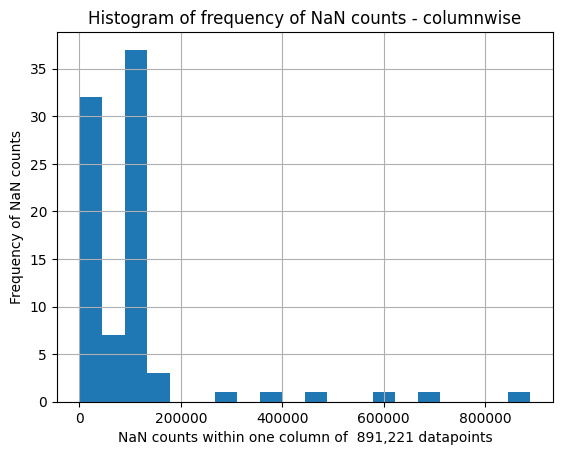

In [16]:
# Investigate patterns in the amount of missing data in each column.
ser_patterns = azdias.isna().sum().sort_values(ascending=False)

plt.hist(ser_patterns, bins=20)
plt.xlabel('NaN counts within one column of  891,221 datapoints')
plt.ylabel('Frequency of NaN counts')
plt.title('Histogram of frequency of NaN counts - columnwise')
plt.grid(True)
plt.show()

For all 85 attributes of azdias there are often missing values. From the visual interpretation of the histogram outliers can be defined as attributes with more than 200,000 missing values. The names of the columns are displayed below.

In [17]:
list_outliers = list(ser_patterns[(ser_patterns > 200000)].index)
print(list_outliers)

['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH']


In [18]:
# number of complete columns
len(ser_patterns[ser_patterns == 0])

24

In [19]:
# Remove the outlier columns from the dataset azdias and from feat_info
azdias = azdias.drop(columns=list_outliers)
feat_info = feat_info.loc[~feat_info.attribute.isin(list_outliers)]

print(azdias.shape, feat_info.shape)

(891221, 79) (79, 4)


In [20]:
print(list_outliers)

['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH']


Let's now calculate the frequency of the NaN count of the dataset. For example, columns with the same number of missing values could be grouped together because they might be from the same source or the like.

In [21]:
ser_missing_data_freq = azdias.isna().sum().value_counts().sort_values(ascending=False)
ser_missing_data_freq.head(5)

0         24
116515     7
4854       6
133324     6
73499      4
Name: count, dtype: int64

Let's put all this information in dataframe and take a closer look:
1. Assign attribute group and frequency to a NaN count in a dictionary
2. Create df_missing_data with attribute, NaN count, frequency and group
3. Drop attributes with no missing data and attributes that only occur once
4. Restructure data in df_pivot
5. Compare attribute groups from df_pivot with information from feat_info

In [22]:
num = 1
value_dict = dict()

# Assign group and frequency to a NaN count in a dictionary
for count, occurence in ser_missing_data_freq.items():
    if occurence == 1:
        group = '1 occurence'
    elif count == 0:
        group = 'no missing data'
    else:
        if num < 10:
            group = 'group 0' + str(num)
        else:
            group = 'group ' + str(num)
        num += 1
    
    value_dict.update({count: {'group': group, 'frequency':occurence}})

value_dict

{0: {'group': 'no missing data', 'frequency': 24},
 116515: {'group': 'group 01', 'frequency': 7},
 4854: {'group': 'group 02', 'frequency': 6},
 133324: {'group': 'group 03', 'frequency': 6},
 73499: {'group': 'group 04', 'frequency': 4},
 93148: {'group': 'group 05', 'frequency': 4},
 98979: {'group': 'group 06', 'frequency': 3},
 111196: {'group': 'group 07', 'frequency': 3},
 93740: {'group': 'group 08', 'frequency': 3},
 158064: {'group': 'group 09', 'frequency': 2},
 97375: {'group': 'group 10', 'frequency': 2},
 77792: {'group': 'group 11', 'frequency': 2},
 147988: {'group': '1 occurence', 'frequency': 1},
 97632: {'group': '1 occurence', 'frequency': 1},
 94572: {'group': '1 occurence', 'frequency': 1},
 108315: {'group': '1 occurence', 'frequency': 1},
 108164: {'group': '1 occurence', 'frequency': 1},
 18348: {'group': '1 occurence', 'frequency': 1},
 2881: {'group': '1 occurence', 'frequency': 1},
 97008: {'group': '1 occurence', 'frequency': 1},
 73969: {'group': '1 occure

In [23]:
# Create a DataFrame with attribute, NaN count, frequency and group
df_missing_data = pd.DataFrame({'attribute':azdias.columns,
                                'NaN count':azdias.isna().sum().values})

df_missing_data['frequency'] = df_missing_data['NaN count'].apply(lambda x: value_dict[x]['frequency'])
df_missing_data['group'] = df_missing_data['NaN count'].apply(lambda x: value_dict[x]['group'])

df_missing_data = df_missing_data.sort_values(by='frequency', ascending=False)
df_missing_data.reset_index(inplace=True, drop=True)
display(df_missing_data.sample(10))

,attribute,NaN count,frequency,group
63,RELAT_AB,97375,2,group 10
55,HEALTH_TYP,111196,3,group 07
34,MOBI_REGIO,133324,6,group 03
62,ARBEIT,97375,2,group 10
23,FINANZTYP,0,24,no missing data
66,GEBAEUDETYP_RASTER,93155,1,1 occurence
44,MIN_GEBAEUDEJAHR,93148,4,group 05
0,ZABEOTYP,0,24,no missing data
73,PRAEGENDE_JUGENDJAHRE,108164,1,1 occurence
29,PLZ8_ANTG3,116515,7,group 01


In [24]:
# Drop attributes with no missing data and attributes that only occur once
df_pivot = df_missing_data[~df_missing_data['group'].isin(['1 occurence', 'no missing data'])]
# Restructure data in pivot_table
df_pivot = pd.pivot_table(data=df_pivot,
                          index='group',
                          values= ['attribute', 'frequency', 'NaN count'],
                          aggfunc={'attribute': lambda x: ', '.join(x),
                                   'frequency': 'first',
                                   'NaN count': 'first'})
df_pivot

,NaN count,attribute,frequency
group,,,
group 01,116515,"PLZ8_BAUMAX, PLZ8_ANTG1, PLZ8_ANTG2, PLZ8_GBZ,...",7
group 02,4854,"LP_STATUS_FEIN, ONLINE_AFFINITAET, CJT_GESAMTT...",6
group 03,133324,"KBA05_ANTG2, KBA05_ANTG3, MOBI_REGIO, KBA05_AN...",6
group 04,73499,"ANZ_PERSONEN, ANZ_TITEL, WOHNDAUER_2008, SOHO_KZ",4
group 05,93148,"MIN_GEBAEUDEJAHR, OST_WEST_KZ, WOHNLAGE, GEBAE...",4
group 06,98979,"CAMEO_DEUG_2015, CAMEO_DEU_2015, CAMEO_INTL_2015",3
group 07,111196,"SHOPPER_TYP, HEALTH_TYP, VERS_TYP",3
group 08,93740,"BALLRAUM, EWDICHTE, INNENSTADT",3
group 09,158064,"KKK, REGIOTYP",2


In [712]:
# Compare attribute groups from df_pivot with information from feat_info

grouped_info_levels = list()
for group in df_pivot.index:
    list_attributes = df_pivot.loc[group, 'attribute'].split(', ')
    list_information_level = feat_info.loc[feat_info['attribute'].isin(list_attributes), 'information_level']
    list_information_level = list(list_information_level)
    grouped_info_levels.extend(item for item in list_information_level)
    
    print(group.upper())
    print(f'number of attributes: {len(list_attributes)}')
    print(list_attributes)
    print()
    print(feat_info[feat_info.attribute.isin(list_attributes)])
    
    if len(list_information_level) > 1:
        print()
        print(f'information_levels in {group.upper()}: {len(list_information_level)} {list_information_level}')
    
    print()
    print()

GROUP 01
number of attributes: 7
['PLZ8_BAUMAX', 'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_GBZ', 'PLZ8_HHZ', 'PLZ8_ANTG3', 'PLZ8_ANTG4']

      attribute information_level     type missing_or_unknown
75   PLZ8_ANTG1    macrocell_plz8  ordinal               [-1]
76   PLZ8_ANTG2    macrocell_plz8  ordinal               [-1]
77   PLZ8_ANTG3    macrocell_plz8  ordinal               [-1]
78   PLZ8_ANTG4    macrocell_plz8  ordinal               [-1]
79  PLZ8_BAUMAX    macrocell_plz8    mixed             [-1,0]
80     PLZ8_HHZ    macrocell_plz8  ordinal               [-1]
81     PLZ8_GBZ    macrocell_plz8  ordinal               [-1]

information_levels in GROUP 01: 7 ['macrocell_plz8', 'macrocell_plz8', 'macrocell_plz8', 'macrocell_plz8', 'macrocell_plz8', 'macrocell_plz8', 'macrocell_plz8']


GROUP 02
number of attributes: 6
['LP_STATUS_FEIN', 'ONLINE_AFFINITAET', 'CJT_GESAMTTYP', 'LP_STATUS_GROB', 'RETOURTYP_BK_S', 'GFK_URLAUBERTYP']

            attribute information_level         type missing_or_

In [713]:
# how often does an information_level in a group occur
[[x, grouped_info_levels.count(x)] for x in set(grouped_info_levels)]

[['macrocell_plz8', 7],
 ['microcell_rr4', 3],
 ['community', 2],
 ['building', 4],
 ['person', 11],
 ['postcode', 3],
 ['household', 3],
 ['region_rr1', 4],
 ['microcell_rr3', 5]]

In [714]:
# how many information_levels are there?
len(feat_info.information_level.unique())

9

In [715]:
for level in sorted(feat_info.information_level.unique()):
    print(level, len(feat_info.loc[feat_info.information_level == level, 'attribute']))

building 7
community 3
household 5
macrocell_plz8 8
microcell_rr3 5
microcell_rr4 3
person 40
postcode 3
region_rr1 5


In [716]:
for item in sorted(set(grouped_info_levels)): 
    print(item, grouped_info_levels.count(item))

building 4
community 2
household 3
macrocell_plz8 7
microcell_rr3 5
microcell_rr4 3
person 11
postcode 3
region_rr1 4


In [717]:
# how many information levels are represented in the groups
len([[x, grouped_info_levels.count(x)] for x in set(grouped_info_levels)])

9

#### Discussion 1.1.2: Assess Missing Data in Each Column

Of all 85 attributes of azdias there are 24 columns in which no data is missing. From the visual interpretation of the histogram, i.e. how missing values are distributed among the columns, I define outliers to be attributes with more than 200,000 missing values. There were 6 columns with more than 200,000 values missing, namely: ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX'], which were removed from the dataset.

Moreover, I found that 11 counts of NaN values occured more than once. I tried to find, whether certain information_levels from feat_info can be clustered together. In other words: are there information_levels where one finds the same amount of missing data? GROUP 01 represents 7 out of 8 attributes of the information_level "macrocell_plz8", i.e. each of the attributes has the same number of missing data. Looking at all groups up to GROUP 11, they are all never fully representative for a information_level, except for Group 08 which consists of 3 attributes of level "postcode". In total, it seems unlikely that in a dataset with more than 800,000 rows, NaN counts occur more than once, up to even 7 times. This might be due to many reasons, but it could be that it has something to do with the data collection and the merge of data. In the introduction to the task there were also hints that the dataset was derived from multiple public sources. This could be communicated with Arvato.  Given the fact, that most of the groups consist of more than just one information_level, it is rather logical that data from one authority is used for various information_levels which are finally determinded by Arvato. Hence, NaN counts might be the same over the borders of information_levels.

Looking at how data is read from the csv-file compared to the intended data types given in feat_info, there is also room for improvement to reduce the computational effort. Columns with no missing data could be converted to integers which require less memory.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [718]:
# How much data is missing in each row of the dataset?
azdias.isna().sum(axis = 1).value_counts().sort_values(ascending=False)

0     623423
47     45578
2      27938
43     27369
8      24598
5      22520
3      17423
1      15742
6      13777
7      13730
4      12609
34     10816
10      5391
15      4765
35      3910
13      3254
9       3031
33      2985
16      2513
14      2248
19      1171
11      1105
12       763
17       671
37       538
45       494
38       421
18       406
41       356
20       350
32       207
44       155
21       151
40       137
23       132
22       128
36        84
39        77
24        68
26        59
25        55
27        24
42        21
29        11
30         6
28         5
31         3
49         2
48         1
dtype: int64

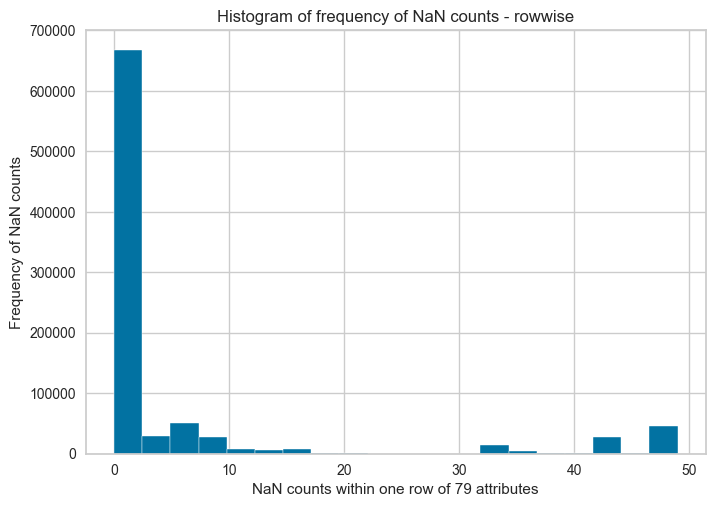

In [719]:
ser_patterns_rows = azdias.isna().sum(axis=1)

plt.hist(ser_patterns_rows, bins=20)
plt.xlabel('NaN counts within one row of 79 attributes')
plt.ylabel('Frequency of NaN counts')
plt.title('Histogram of frequency of NaN counts - rowwise')
plt.grid(True)
plt.show()

In [720]:
# Write code to divide the data into two subsets based on the number of missing values in each row.

group1 = azdias.loc[ser_patterns_rows[(ser_patterns_rows>30)].index]
group2 = azdias.loc[ser_patterns_rows[(ser_patterns_rows<=30)].index]

In [721]:
# What does the data division correspond to relatively?
group1_rel = round(len(group1)/(len(group1) + len(group2))*100, 2)
group2_rel = round(len(group2)/(len(group1) + len(group2))*100, 2)

print(f'Group 1 corresponds to {group1_rel}% and '
      f'group 2 represents {group2_rel}% of the dataset.')

Group 1 corresponds to 10.45% and group 2 represents 89.55% of the dataset.


In [722]:
# randomly select 5 of the ordinal attributes

import random
# get all ordinal attributes of dataset for plotting
ord_attr = feat_info[feat_info.type == 'ordinal']
ord_attr = list(ord_attr.attribute)
# randomly choose from list 5 ordinal attributes

list_samples = list()
while len(list_samples) != 5:
    rand_sample = random.choice(ord_attr)
    
    # make sure that there is data in group1 and group2 for chosen rand_sample
    test_group1 = group1.loc[:, rand_sample].isnull().values.all()
    test_group2 = group2.loc[:, rand_sample].isnull().values.all()
    
    if test_group1 or test_group2:
        next
    else:
        list_samples.append(rand_sample)

list_samples

['SEMIO_REL',
 'ORTSGR_KLS9',
 'FINANZ_SPARER',
 'WOHNDAUER_2008',
 'FINANZ_SPARER']

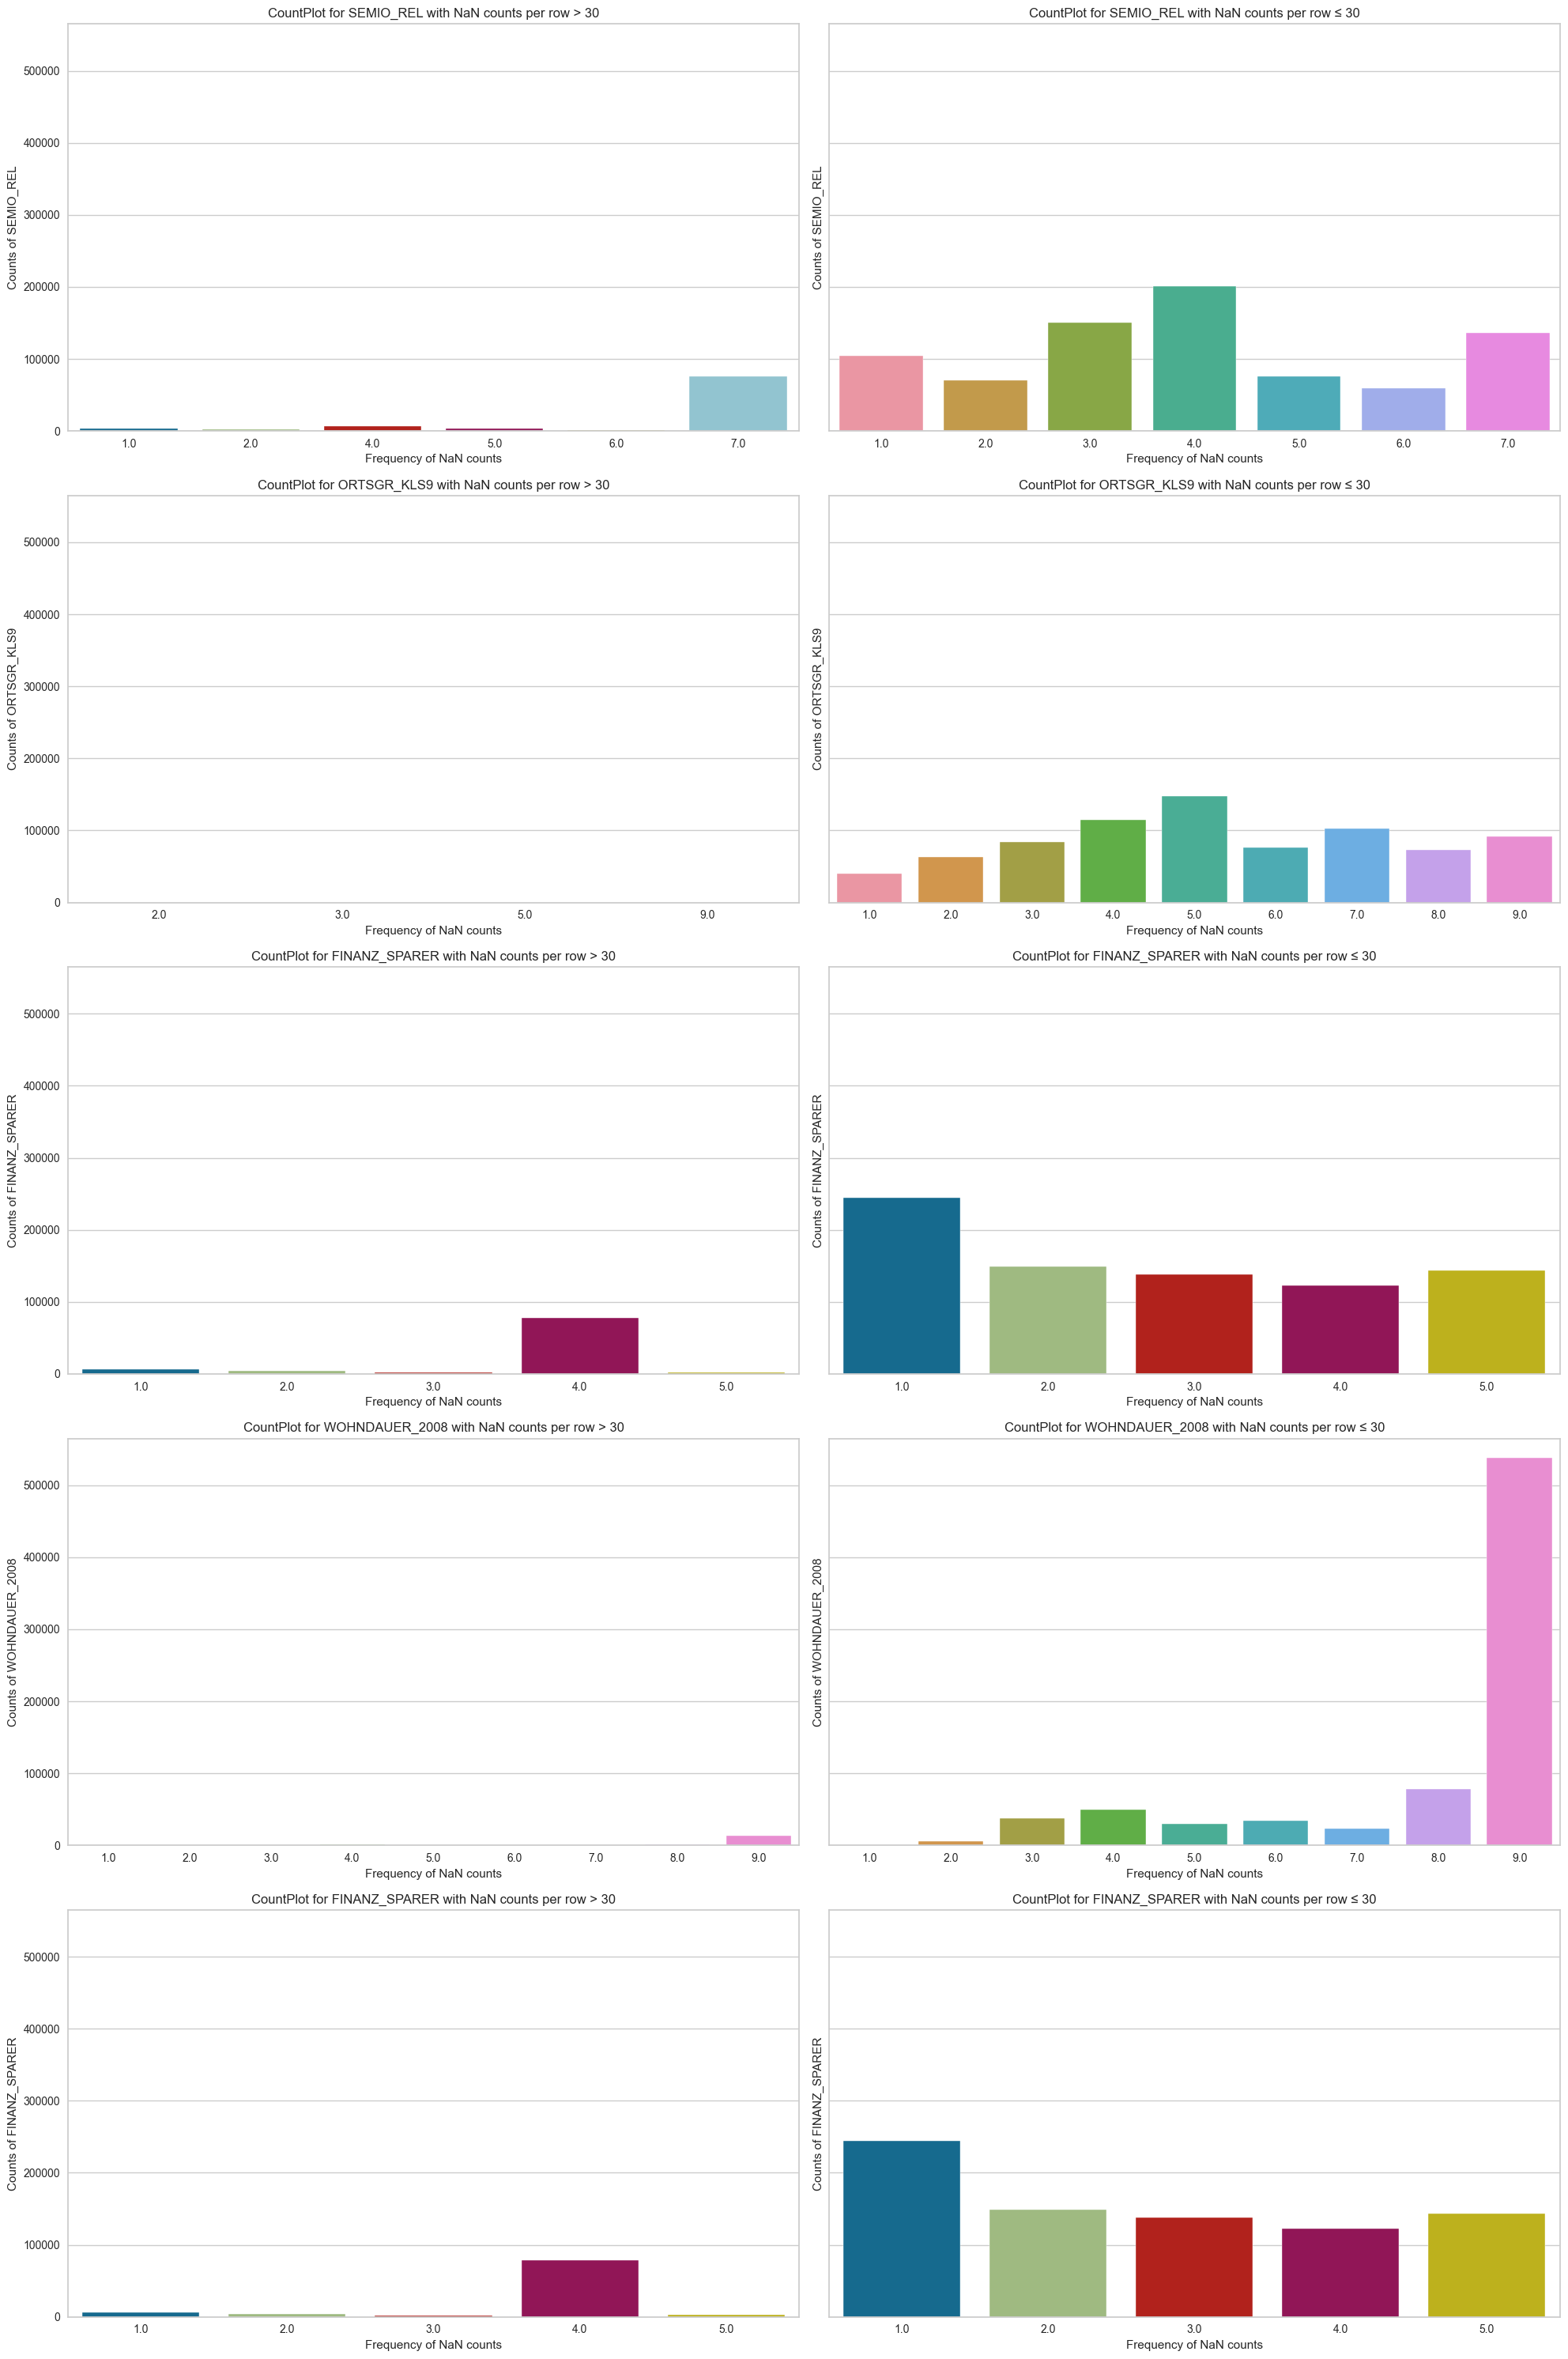

In [723]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20,30), sharey=True)
n=0

for attr in list_samples:
    data_group1 = group1.loc[:, attr]
    sns.countplot(x=data_group1, ax=axes[n,0])
    axes[n,0].set_title(f'CountPlot for {attr} with NaN counts per row > 30')
    axes[n,0].set_xlabel('Frequency of NaN counts')
    axes[n,0].set_ylabel(f'Counts of {attr}')
    
    data_group2 = group2.loc[:, attr]
    sns.countplot(x=data_group2, ax=axes[n,1])
    axes[n,1].set_title(f'CountPlot for {attr} with NaN counts per row ≤ 30')
    axes[n,1].set_xlabel('Frequency of NaN counts')
    axes[n,1].set_ylabel(f'Counts of {attr}')
    
    n+=1
    
fig.tight_layout()

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

Data of the 2 groups with threshold 30 from 5 randomly picked attributes look very different when using a shared y-axis. Hence, I conclude both should be kept for further analysis and neither should be dropped in order to not distort the data.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [724]:
# How many features are there of each data type?
feat_info.type.value_counts()

ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [725]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

cat_attr = feat_info.loc[feat_info.type == 'categorical', 'attribute'].values

list_binary = list()
list_multi = list()

for attr in cat_attr:
    ser_attr = pd.Series(azdias[attr].unique())
    ser_attr = ser_attr[~ser_attr.isnull()]
    
    # check for binary data
    if len(ser_attr) == 2:
        list_binary.append(attr)
        
        try:
            if ser_attr.cat.categories.dtype == 'object':
            # replace non-numeric binary data (string)
                n=0
                for i in ser_attr:
                    azdias[attr] = azdias[attr].replace(i, n)
                    n+=1
        except AttributeError:
            next
            
    if len(ser_attr) > 2:
        list_multi.append(attr)
            
print(f'binary: {list_binary}\n'
      f'multi-level: {list_multi}')

binary: ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']
multi-level: ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [726]:
azdias_dtypes = azdias.dtypes
azdias_columns = azdias.columns

In [727]:
# Re-encode categorical variable(s) to be kept in the analysis.
# hot-encode all multi-level categories

azdias = pd.get_dummies(data=azdias, columns=list_multi)
azdias.shape

(891221, 200)

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

I didn't find indication that categorical features needed to be dropped. Instead I re-encoded attributes which so far were classified as objects, using Pandas' get_dummies() one-hot-encoding. The attribute 'OST_WEST_KZ' represents binary data of type 'object' which is where I listed it beforehand.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [728]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
dict_jugend = {-1: 'unknown',
               0: 'unknown', 
               1: '40s - war years (Mainstream, E+W)',
               2: '40s - reconstruction years (Avantgarde, E+W)',
               3: '50s - economic miracle (Mainstream, E+W)',
               4: '50s - milk bar / Individualisation (Avantgarde, E+W)',
               5: '60s - economic miracle (Mainstream, E+W)',
               6: '60s - generation 68 / student protestors (Avantgarde, W)',
               7: '60s - opponents to the building of the Wall (Avantgarde, E)',
               8: '70s - family orientation (Mainstream, E+W)',
               9: '70s - peace movement (Avantgarde, E+W)',
               10: '80s - Generation Golf (Mainstream, W)',
               11: '80s - ecological awareness (Avantgarde, W)',
               12: '80s - FDJ / communist party youth organisation (Mainstream, E)',
               13: '80s - Swords into ploughshares (Avantgarde, E)',
               14: '90s - digital media kids (Mainstream, E+W)',
               15: '90s - ecological awareness (Avantgarde, E+W)'}

dict_mainstream = dict()
dict_years = dict()

# create dictionaries to map on column
for key, value in dict_jugend.items():
    if 'Mainstream' in value:
        # 1 for mainstream, 0 for avantgarde
        dict_mainstream.update({key:1})
    else: 
        dict_mainstream.update({key:0})
    
    try:
        dict_years.update({key: int(value[:2])/100})
        # so it's better to handle for an algorithm divided by 100
    except ValueError:
        dict_years.update({key: np.nan})
        
        
azdias['JUGENDJAHRE_MAINSTREAM'] = azdias.loc[:, 'PRAEGENDE_JUGENDJAHRE'].map(dict_mainstream)
azdias['JUGENDJAHRE_JAHRE'] = azdias.loc[:, 'PRAEGENDE_JUGENDJAHRE'].map(dict_years)
azdias.drop(columns='PRAEGENDE_JUGENDJAHRE', inplace=True)

1.18. PRAEGENDE_JUGENDJAHRE

Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)

    -1: unknown
    0: unknown
    1: 40s - war years (Mainstream, E+W)
    2: 40s - reconstruction years (Avantgarde, E+W)
    3: 50s - economic miracle (Mainstream, E+W)
    4: 50s - milk bar / Individualisation (Avantgarde, E+W)
    5: 60s - economic miracle (Mainstream, E+W)
    6: 60s - generation 68 / student protestors (Avantgarde, W)
    7: 60s - opponents to the building of the Wall (Avantgarde, E)
    8: 70s - family orientation (Mainstream, E+W)
    9: 70s - peace movement (Avantgarde, E+W)
    10: 80s - Generation Golf (Mainstream, W)
    11: 80s - ecological awareness (Avantgarde, W)
    12: 80s - FDJ / communist party youth organisation (Mainstream, E)
    13: 80s - Swords into ploughshares (Avantgarde, E)
    14: 90s - digital media kids (Mainstream, E+W)
    15: 90s - ecological awareness (Avantgarde, E+W)
    
3. CAMEO_INTL_2015

German CAMEO: Wealth / Life Stage Typology, mapped to international code

    -1: unknown
    11: Wealthy Households - Pre-Family Couples & Singles
    12: Wealthy Households - Young Couples With Children
    13: Wealthy Households - Families With School Age Children
    14: Wealthy Households - Older Families & Mature Couples
    15: Wealthy Households - Elders In Retirement
    21: Prosperous Households - Pre-Family Couples & Singles
    22: Prosperous Households - Young Couples With Children
    23: Prosperous Households - Families With School Age Children
    24: Prosperous Households - Older Families & Mature Couples
    25: Prosperous Households - Elders In Retirement
    31: Comfortable Households - Pre-Family Couples & Singles
    32: Comfortable Households - Young Couples With Children
    33: Comfortable Households - Families With School Age Children
    34: Comfortable Households - Older Families & Mature Couples
    35: Comfortable Households - Elders In Retirement
    41: Less Affluent Households - Pre-Family Couples & Singles
    42: Less Affluent Households - Young Couples With Children
    43: Less Affluent Households - Families With School Age Children
    44: Less Affluent Households - Older Families & Mature Couples
    45: Less Affluent Households - Elders In Retirement
    51: Poorer Households - Pre-Family Couples & Singles
    52: Poorer Households - Young Couples With Children
    53: Poorer Households - Families With School Age Children
    54: Poorer Households - Older Families & Mature Couples
    55: Poorer Households - Elders In Retirement
    XX: unknown


In [729]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
dict_cameo = {'-1': 'unknown',
              '11': 'Wealthy Households - Pre-Family Couples & Singles',
              '12': 'Wealthy Households - Young Couples With Children',
              '13': 'Wealthy Households - Families With School Age Children',
              '14': 'Wealthy Households - Older Families & Mature Couples',
              '15': 'Wealthy Households - Elders In Retirement',
              '21': 'Prosperous Households - Pre-Family Couples & Singles',
              '22': 'Prosperous Households - Young Couples With Children',
              '23': 'Prosperous Households - Families With School Age Children',
              '24': 'Prosperous Households - Older Families & Mature Couples',
              '25': 'Prosperous Households - Elders In Retirement',
              '31': 'Comfortable Households - Pre-Family Couples & Singles',
              '32': 'Comfortable Households - Young Couples With Children',
              '33': 'Comfortable Households - Families With School Age Children',
              '34': 'Comfortable Households - Older Families & Mature Couples',
              '35': 'Comfortable Households - Elders In Retirement',
              '41': 'Less Affluent Households - Pre-Family Couples & Singles',
              '42': 'Less Affluent Households - Young Couples With Children',
              '43': 'Less Affluent Households - Families With School Age Children',
              '44': 'Less Affluent Households - Older Families & Mature Couples',
              '45': 'Less Affluent Households - Elders In Retirement',
              '51': 'Poorer Households - Pre-Family Couples & Singles',
              '52': 'Poorer Households - Young Couples With Children',
              '53': 'Poorer Households - Families With School Age Children',
              '54': 'Poorer Households - Older Families & Mature Couples',
              '55': 'Poorer Households - Elders In Retirement',
              'XX': 'unknown'}

dict_houshold = dict()
dict_family = dict()

for key, value in dict_cameo.items():
    household = value.split(' - ')[0]
    if household == 'Comfortable Households': dict_houshold.update({key: '0'})
    if household == 'Less Affluent Households': dict_houshold.update({key: '1'})
    if household == 'Poorer Households': dict_houshold.update({key: '2'})
    if household == 'Prosperous Households': dict_houshold.update({key: '3'})
    if household == 'Wealthy Households': dict_houshold.update({key: '4'})
    
    try:
        family = value.split(' - ')[1]
        if family == 'Elders In Retirement': dict_family.update({key: '0'})
        if family == 'Families With School Age Children': dict_family.update({key: '1'})
        if family == 'Older Families & Mature Couples': dict_family.update({key: '2'})
        if family == 'Pre-Family Couples & Singles': dict_family.update({key: '3'})
        if family == 'Young Couples With Children': dict_family.update({key: '4'})
        
    except IndexError:
        next
        
azdias['CAMEO_INTL_2015_HOUSEHOLD'] = azdias['CAMEO_INTL_2015'].map(dict_houshold)
azdias['CAMEO_INTL_2015_FAMILY'] = azdias['CAMEO_INTL_2015'].map(dict_family)

azdias.drop(columns='CAMEO_INTL_2015', inplace=True)

In [730]:
azdias = pd.get_dummies(data=azdias, columns=['CAMEO_INTL_2015_HOUSEHOLD', 'CAMEO_INTL_2015_FAMILY'])
azdias.shape

(891221, 210)

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

In one of the first steps of preprocessing I observed, that the type of data indicated in feat_info and the coerced data type after read_csv differ and could be improved especially to reduce the computational effort for the application of certain algorithms in the following steps. There I changed datatypes of several columns to categorical data (https://pandas.pydata.org/docs/user_guide/categorical.html) which however still keeps an underlying data type such as string ('object'), float or integer. The last point I realised when taking a closer look at [1.2.1: Re-Encode Categorical Features](#1-2-1--Re-Encode-Categorical-Features) where I changed several datatypes. 
***
***Categorical data***:
+ Binary numeric and categorical data I left untouched,
+ Non-binary catagorical string data I converted into dummy/indicator variables using get_dummies (https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html) and dropped the corresponding initial column.
***
***Mixed-type data***:
+ For the feature PRAEGENDE_JUGENDJAHRE I created a dictionary from 'Data_Dictionary.md' and separated information on mainstream/avantgarde and years into two columns (PRAEGENDE_JUGENDJAHRE_MAINSTREAM, PRAEGENDE_JUGENDJAHRE_YEARS). Mainstream I encoded binary, i.e. 1: mainstream, 0: non-mainstream (avantgarde). Years I simply kept as two digit year divided by 100.
+ From CAMEO_INTL_2015 I again extracted data concerning household and family (CAMEO_INTL_2015_HOUSEHOLD, CAMEO_INTL_2015_FAMILY) in accordance to 'Data_Dictionary.md'.
+ Houshold data I encoded as follows: 
    + Comfortable Households : 0
    + Less Affluent Households: 1
    + Poorer Households : 2
    + Prosperous Households : 3
    + Wealthy Households : 4
    + unknown': np.nan
+ Family data:
    + Elders In Retirement : 0
    + Families With School Age Children : 1
    + Older Families & Mature Couples : 2
    + Pre-Family Couples & Singles : 3
    + Young Couples With Children : 4

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [731]:
sorted(azdias.columns)

['ALTERSKATEGORIE_GROB',
 'ANREDE_KZ',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'ARBEIT',
 'BALLRAUM',
 'CAMEO_DEUG_2015_1',
 'CAMEO_DEUG_2015_2',
 'CAMEO_DEUG_2015_3',
 'CAMEO_DEUG_2015_4',
 'CAMEO_DEUG_2015_5',
 'CAMEO_DEUG_2015_6',
 'CAMEO_DEUG_2015_7',
 'CAMEO_DEUG_2015_8',
 'CAMEO_DEUG_2015_9',
 'CAMEO_DEUG_2015_X',
 'CAMEO_DEU_2015_1A',
 'CAMEO_DEU_2015_1B',
 'CAMEO_DEU_2015_1C',
 'CAMEO_DEU_2015_1D',
 'CAMEO_DEU_2015_1E',
 'CAMEO_DEU_2015_2A',
 'CAMEO_DEU_2015_2B',
 'CAMEO_DEU_2015_2C',
 'CAMEO_DEU_2015_2D',
 'CAMEO_DEU_2015_3A',
 'CAMEO_DEU_2015_3B',
 'CAMEO_DEU_2015_3C',
 'CAMEO_DEU_2015_3D',
 'CAMEO_DEU_2015_4A',
 'CAMEO_DEU_2015_4B',
 'CAMEO_DEU_2015_4C',
 'CAMEO_DEU_2015_4D',
 'CAMEO_DEU_2015_4E',
 'CAMEO_DEU_2015_5A',
 'CAMEO_DEU_2015_5B',
 'CAMEO_DEU_2015_5C',
 'CAMEO_DEU_2015_5D',
 'CAMEO_DEU_2015_5E',
 'CAMEO_DEU_2015_5F',
 'CAMEO_DEU_2015_6A',
 'CAMEO_DEU_2015_6B',
 'CAMEO_DEU_2015_6C',
 'CAMEO_DEU_2015_6D',
 'CAMEO_DEU_2015_6E',
 'CAMEO

In [732]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [733]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [760]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    feat_info_red = feat_info[~feat_info['attribute'].isin(list_outliers)]
      
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    for attribute, missing_or_unknown in zip(feat_info_red['attribute'], feat_info_red['missing_or_unknown']):
        mask_missing_or_unknown_int = [int(i) for i in re.findall(r'-?\d', missing_or_unknown)]
        mask_missing_or_unknown_int = df[attribute].isin(mask_missing_or_unknown_int)
        df.loc[mask_missing_or_unknown_int, attribute] = np.nan
    
    # remove selected columns in accordance to list_outliers from azdias dataset
    df.drop(columns=list_outliers, inplace=True)
    
    # change dtypes of columns
    for col, dtype in zip(df.columns, azdias_dtypes):
        df[col] = df[col].astype(dtype)
    
    # remove selected rows
    ser_rows = df.isna().sum(axis=1)
    list_row_idx = list(ser_rows[(ser_rows > 30)].index)
    df.drop(index=list_row_idx, inplace=True)
    
    # select, re-encode, and engineer column values.
    cat_attr = feat_info_red.loc[feat_info.type == 'categorical', 'attribute'].values

    list_binary = list()
    list_multi = list()

    for attr in cat_attr:
        ser_attr = pd.Series(df[attr].unique())
        ser_attr = ser_attr[~ser_attr.isnull()]

        # check for binary data
        if len(ser_attr) == 2:
            list_binary.append(attr)

            try:
                if ser_attr.dtype == 'O':
                # replace non-numeric binary data (string)
                    n=0
                    for i in ser_attr:
                        df[attr] = df[attr].replace(i, n)
                        n+=1
            except AttributeError:
                next

        if len(ser_attr) > 2:
            list_multi.append(attr)
    
    # Re-encode categorical variable(s) to be kept in the analysis.
    # hot-encode all multi-level categories
    df = pd.get_dummies(data=df, columns=list_multi)

    # make features out of JUGENDJAHRE_MAINSTREAM
    df['JUGENDJAHRE_MAINSTREAM'] = df.loc[:, 'PRAEGENDE_JUGENDJAHRE'].map(dict_mainstream)
    df['JUGENDJAHRE_JAHRE'] = df.loc[:, 'PRAEGENDE_JUGENDJAHRE'].map(dict_years)
    df.drop(columns='PRAEGENDE_JUGENDJAHRE', inplace=True)
    
    # make features out of CAMEO_INTL_2015 and map with respective dictionaries
    df['CAMEO_INTL_2015_HOUSEHOLD'] = df['CAMEO_INTL_2015'].map(dict_houshold)
    df['CAMEO_INTL_2015_FAMILY'] = df['CAMEO_INTL_2015'].map(dict_family)
    df.drop(columns='CAMEO_INTL_2015', inplace=True)
    
    # hot-encode both created features
    df = pd.get_dummies(data=df, columns=['CAMEO_INTL_2015_HOUSEHOLD', 'CAMEO_INTL_2015_FAMILY'])
    
    # Return the cleaned dataframe.
    return df

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [735]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

impute_mf = SimpleImputer(strategy='most_frequent')
azdias_clean_imputed = pd.DataFrame(impute_mf.fit_transform(azdias))

In [736]:
azdias_clean_imputed.head()

,0,1,2,3,4,5,6,7,8,9,...,200,201,202,203,204,205,206,207,208,209
0,2.0,1.0,3.0,4.0,3.0,5.0,5.0,3.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0.0,2.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [737]:
azdias_clean_imputed.columns = azdias.columns
azdias_clean_imputed.index = azdias.index
azdias_clean_imputed.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_INTL_2015_HOUSEHOLD_0,CAMEO_INTL_2015_HOUSEHOLD_1,CAMEO_INTL_2015_HOUSEHOLD_2,CAMEO_INTL_2015_HOUSEHOLD_3,CAMEO_INTL_2015_HOUSEHOLD_4,CAMEO_INTL_2015_FAMILY_0,CAMEO_INTL_2015_FAMILY_1,CAMEO_INTL_2015_FAMILY_2,CAMEO_INTL_2015_FAMILY_3,CAMEO_INTL_2015_FAMILY_4
0,2.0,1.0,3.0,4.0,3.0,5.0,5.0,3.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0.0,2.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [738]:
# Apply feature StandardScaler to the "most frequent" imputed general population demographics data
scaler = StandardScaler()
azdias_clean_imputed_ss = pd.DataFrame(scaler.fit_transform(azdias_clean_imputed),
                                       columns = azdias_clean_imputed.columns)

### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

I imputed data using the "most frequent" method since it can also be applied to categorical features unlike mean or median which produce poor results on encoded categorical features (https://towardsdatascience.com/6-different-ways-to-compensate-for-missing-values-data-imputation-with-examples-6022d9ca0779). However, this method doesn't factor correlations between features and can introduce bias in the data.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [739]:
# Apply PCA to the data.
pca = PCA()
pca.fit(azdias_clean_imputed_ss)

print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[7.64685624e-02 5.22582178e-02 3.62529113e-02 2.77877530e-02
 2.69368031e-02 2.13325820e-02 1.76065627e-02 1.57774374e-02
 1.51475880e-02 1.43158927e-02 1.34777145e-02 1.30338316e-02
 1.23882596e-02 1.18711642e-02 1.15808665e-02 1.12343756e-02
 1.08624083e-02 1.06547158e-02 1.02950660e-02 1.01466644e-02
 9.92660338e-03 9.85300110e-03 9.65413273e-03 9.42501761e-03
 9.19788407e-03 9.09818413e-03 8.21099205e-03 8.16035159e-03
 7.88183540e-03 7.62226205e-03 7.40039031e-03 7.24925360e-03
 7.06223807e-03 6.79217520e-03 6.70657967e-03 6.50503011e-03
 6.37375200e-03 6.28718232e-03 6.22383521e-03 6.16044906e-03
 6.01059600e-03 5.90176528e-03 5.88450333e-03 5.79450106e-03
 5.67284119e-03 5.59736197e-03 5.55067444e-03 5.48898865e-03
 5.37018179e-03 5.32299080e-03 5.30091474e-03 5.24088114e-03
 5.21420492e-03 5.20599984e-03 5.14369442e-03 5.11326753e-03
 5.07020320e-03 5.06200095e-03 5.03175406e-03 5.01493927e-03
 5.00385430e-03 4.99313742e-03 4.98853398e-03 4.97425904e-03
 4.96465764e-03 4.953919

In [740]:
# Investigate the variance accounted for by each principal component (PC).

# principal component indexing
dimensions = dimensions = [f'PC_{i}' for i in range(1,len(pca.components_)+1)]

# explained variance
ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
variance_ratios.index = dimensions

variance_ratios.head(10)

,Explained Variance
PC_1,0.0765
PC_2,0.0523
PC_3,0.0363
PC_4,0.0278
PC_5,0.0269
PC_6,0.0213
PC_7,0.0176
PC_8,0.0158
PC_9,0.0151
PC_10,0.0143


In [741]:
# specify the explained variance and get according number of principal components
x_variance = 0.85

for idx, var in variance_ratios.iterrows():
    explained_variance = variance_ratios.loc[:idx].sum().values[0]
    if explained_variance > x_variance:
        print(f'The use of {len(variance_ratios.loc[:idx])} principal components explain '
              f'{round(explained_variance*100, 2)} % of the cleaned, imputed and standardised data.')
        break

The use of 95 principal components explain 85.4 % of the cleaned, imputed and standardised data.


In [742]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=95)
azdias_pca = pca.fit_transform(azdias_clean_imputed_ss)
azdias_pca

array([[ 1.87154221, -1.56727534, -4.17100317, ..., -0.20705708,
         0.25843419, -0.04773585],
       [ 4.57571898, -3.81438137,  0.24420595, ..., -2.71954094,
        -1.90684361,  1.74059582],
       [-0.53206602, -0.53197166, -1.70846207, ...,  0.70296528,
        -0.15109212,  0.43930164],
       ...,
       [-1.18836292, -3.81597447, -1.0768795 , ..., -0.03476766,
         0.34118248,  0.6881333 ],
       [ 5.92742727, -3.576307  ,  5.27224119, ...,  1.07157066,
         1.54459813,  0.97731755],
       [ 0.36367811,  3.06532898,  1.37041218, ..., -0.59560554,
         0.4178745 , -0.37399727]])

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

When applied to the dataset, the use of 95 principal components explains 85.4 % of variance in the data. The manually chosen threshold can also be set differently, I chose it in accordance to the previous excercise in the mini-project concerning PCA. The use of only 95 components implies a reduction of the initial dataset down to only 45.2 %.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [743]:
# create DataFrame with pca weights
df_pca = pd.DataFrame(data=pca.components_,
                          index=[f'PC_{i}' for i in range(1,len(pca.components_)+1)],
                          columns=azdias_clean_imputed_ss.columns)

df_pca.sample(5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_INTL_2015_HOUSEHOLD_0,CAMEO_INTL_2015_HOUSEHOLD_1,CAMEO_INTL_2015_HOUSEHOLD_2,CAMEO_INTL_2015_HOUSEHOLD_3,CAMEO_INTL_2015_HOUSEHOLD_4,CAMEO_INTL_2015_FAMILY_0,CAMEO_INTL_2015_FAMILY_1,CAMEO_INTL_2015_FAMILY_2,CAMEO_INTL_2015_FAMILY_3,CAMEO_INTL_2015_FAMILY_4
PC_18,0.020674,0.002961,-0.011048,-0.003409,0.050732,-0.032577,0.066615,-0.026296,-0.025225,-0.047659,...,-0.011943,-0.067274,0.107637,-0.042939,-0.009054,0.000364,0.059929,-0.172467,0.112713,0.000434
PC_49,0.055844,-0.006789,-0.018192,0.031124,-0.005401,0.022408,0.000324,-0.013319,0.016843,-0.072645,...,-0.006474,-0.013508,0.031591,-0.004932,-0.005473,0.016776,-0.001699,-0.004153,-0.002417,0.001321
PC_64,0.031502,-0.031584,0.016015,-0.007939,-0.003046,-0.012134,0.006897,0.017019,0.004180,-0.023338,...,-0.001171,-0.004653,0.000249,-0.000832,-0.002160,-0.011328,0.000070,-0.007785,0.009008,0.000051
PC_33,-0.031628,0.031750,0.014204,-0.018084,0.029541,0.014753,-0.010773,-0.034276,-0.014514,-0.104632,...,0.025065,0.045360,-0.006535,-0.037240,-0.015754,-0.088860,-0.147253,0.109131,0.057686,0.029472
PC_6,0.058695,-0.119880,0.076230,-0.032234,0.061787,0.030378,-0.033741,-0.021867,-0.196076,0.029510,...,-0.048722,-0.022927,0.069619,0.019180,-0.179048,-0.010585,-0.016737,-0.114621,0.012518,0.031100


In [744]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# create pca_weights function

def pca_weights (df_pca, num):
    weights_sorted = df_pca.loc[f'PC_{num}'].sort_values(ascending=False)
    return print(f'Weights for component {num}'), weights_sorted

pca_weights(df_pca, 1)

Weights for component 1


(None,
 PLZ8_ANTG3            0.180964
 LP_STATUS_GROB_1.0    0.177553
 PLZ8_BAUMAX           0.159592
 PLZ8_ANTG4            0.156016
 EWDICHTE              0.151723
                         ...   
 KBA05_ANTG1          -0.174603
 KBA05_GBZ            -0.176048
 MOBI_REGIO           -0.179250
 FINANZ_MINIMALIST    -0.180781
 PLZ8_ANTG1           -0.181486
 Name: PC_1, Length: 210, dtype: float64)

In [745]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_weights(df_pca, 2)

Weights for component 2


(None,
 ALTERSKATEGORIE_GROB     0.229774
 FINANZ_VORSORGER         0.221107
 SEMIO_ERL                0.175078
 RETOURTYP_BK_S           0.155783
 SEMIO_LUST               0.149757
                            ...   
 SEMIO_REL               -0.218282
 FINANZ_ANLEGER          -0.226419
 FINANZ_UNAUFFAELLIGER   -0.229825
 FINANZ_SPARER           -0.238491
 JUGENDJAHRE_JAHRE       -0.241965
 Name: PC_2, Length: 210, dtype: float64)

In [746]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_weights(df_pca, 3)

Weights for component 3


(None,
 SEMIO_VERT       0.282024
 SEMIO_KULT       0.254592
 SEMIO_SOZ        0.251991
 SEMIO_FAM        0.139740
 SHOPPER_TYP_0    0.122516
                    ...   
 ZABEOTYP_3      -0.183050
 ANREDE_KZ       -0.221870
 SEMIO_DOM       -0.229532
 SEMIO_KAEM      -0.259934
 SEMIO_KRIT      -0.274666
 Name: PC_3, Length: 210, dtype: float64)

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

* PC_1 has positive associations with:
    * PLZ8_ANTG3, i.e. number of 6-10 family houses in the PLZ8 region (0.180964),
    * LP_STATUS_GROB_1.0, i.e. rough social status (0.177553),
    * PLZ8_BAUMAX, i.e. most common building type within the PLZ8 region (0.159592),
    * PLZ8_ANTG4, i.e. number of 10+ family houses in the PLZ8 region (0.156016)
    * and EWDICHTE, i.e. density of households per square kilometer (0.151723). This could mean that it primarily measures...
* PC_2 has positive associations with:
    * ALTERSKATEGORIE_GROB, i.e. estimated age based on given name analysis (0.229774),
    * FINANZ_VORSORGER, i.e. prepared financer (0.221107),
    * SEMIO_ERL, i.e. event-oriented personal typology (0.175078),
    * RETOURTYP_BK_S, i.e. return type (0.155783),
    * SEMIO_LUST, i.e. sensual-minded personal typology (0.149757). This could mean that it primarily measures...
* PC_3 has positive associations with EMIO_VERT (0.282024), SEMIO_KULT (0.254592), SEMIO_SOZ (0.251991), SEMIO_FAM (0.139740) and SHOPPER_TYP_0 (0.122516). This could mean that it primarily measures...

In general, it can be seen that highest feature weights measure in a similar or related field. However, it is hard to put a label on what exactly that corresponds to but this is also what makes the beauty of PCA.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [622]:
def kmeans_sse(data, n_clusters):
    '''
    returns KMeans SSE score for chosen number of clusters
    INPUT:
        data - the dataset you want to fit kmeans to
        n_clusters - number of clusters
    OUTPUT:
        score - SSE for KMeans model fit to input data
    '''
    # instantiate kmeans
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    # fit model to data
    model = kmeans.fit(data)
    # obtain score in accordance to model fit
    score = np.abs(model.score(data))
    return score

In [ ]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.

sse = []
clusters = list(range(1,31))

# Investigate the change in within-cluster distance across number of clusters.
for n_clusters in clusters:
    sse.append(kmeans_sse(azdias_pca, n_clusters))

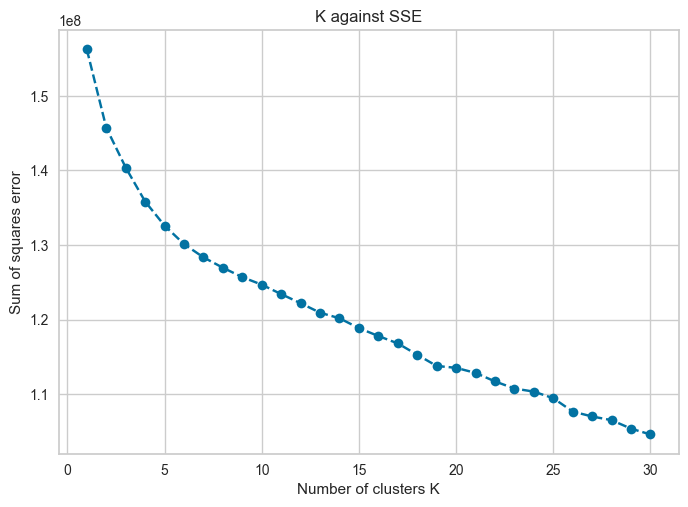

In [499]:
# use matplotlib's plot function to visualize n_clusters against SSE.

plt.plot(clusters, sse, linestyle='--', marker='o', color='b');
#plt.plot(clusters, np.gradient(sse), linestyle='--', marker='o', color='r');
plt.xlabel('Number of clusters K');
plt.ylabel('Sum of squares error');
plt.title('K against SSE');

In [623]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmean = KMeans(n_clusters=17, n_init=10, random_state= 42)
model_general = kmean.fit(azdias_pca)
azdias_general_pred = model_general.predict(azdias_pca)

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

Plotting n_clusters against SSE and the so-called silhouette plots (https://towardsdatascience.com/elbow-method-is-not-sufficient-to-find-best-k-in-k-means-clustering-fc820da0631d) support the decision to fit and predict the data of the general population to XXX clusters. Since the elbow-plot does not give a clear result silhouette plots were conducted. For the selection of K following conditions must be met:
* For a particular K, all the clusters should have a Silhouette score more than the average score of the dataset (represented by a red dotted line). The x-axis represents the Silhouette score. ***The clusters with K = 4 and 5 get eliminated as they don’t follow this condition.***
* There should not be wide fluctuations in the size of the clusters. The width of the clusters represents the number of data points. ***For K = 2, the blue cluster has almost twice the width as compared to the green cluster. This blue cluster gets broken down into 2 sub-clusters for K = 3 and thus forms clusters of uniform size.***

The combination of both mehthods gives ***K = 17 as the optimal value.***

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [747]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')
customers.sample(5)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
81173,1,4,2,2.0,3,1,5,2,1,5,...,2.0,4.0,2.0,0.0,2.0,3.0,2.0,3.0,7.0,5.0
104094,-1,4,1,6.0,4,1,5,1,1,4,...,1.0,4.0,3.0,2.0,4.0,2.0,1.0,3.0,8.0,5.0
159829,-1,2,2,6.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19478,-1,2,2,6.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
145242,-1,3,1,4.0,5,4,2,4,3,2,...,2.0,3.0,1.0,0.0,1.0,5.0,5.0,2.0,2.0,2.0


In [748]:
print(f'customers shape: {customers_clean.shape}\n'
      f'azdias shape: {azdias_clean_imputed_ss.shape}')

customers shape: (141725, 204)
azdias shape: (891221, 210)


There are 2 ways a cleaning function can be applied to the uncleaned customer data:
* Applying a cleaning function that follows the exact steps as done to the azdias dataset. However, this can result in a different amount of features, since missing data can be distributed differently so that set values, e.g. more than 200,000 missing values in a column.
* Applying a cleaning function following a fixed list of features in accordance to missing data of azdias and from there continue with re-encoding data and the creation of dummies. *The creation of dummies could potentially also result in a different set of features, depending on the previously unique values in a column.* The goal of this is to create a cleaned customer dataset that meets the number of features of the azdias dataset.

In [832]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')
customers_clean = clean_data(customers)
customers_clean_columns = customers_clean.columns

# impute data using SimpleImputer with most_frequent strategy
customers_clean = impute_mf.transform(customers_clean)
customers_clean = pd.DataFrame(data=customers_clean, columns=customers_clean_columns)

# normalize data using StandardScaler
customers_clean = scaler.transform(customers_clean)
customers_clean = pd.DataFrame(data=customers_clean, columns=customers_clean_columns)

# transform data using pca with n_components=95
customers_clean_pca = pca.transform(customers_clean)

# predict clustering using KMeans object
predict_customers = model_general.predict(customers_clean_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

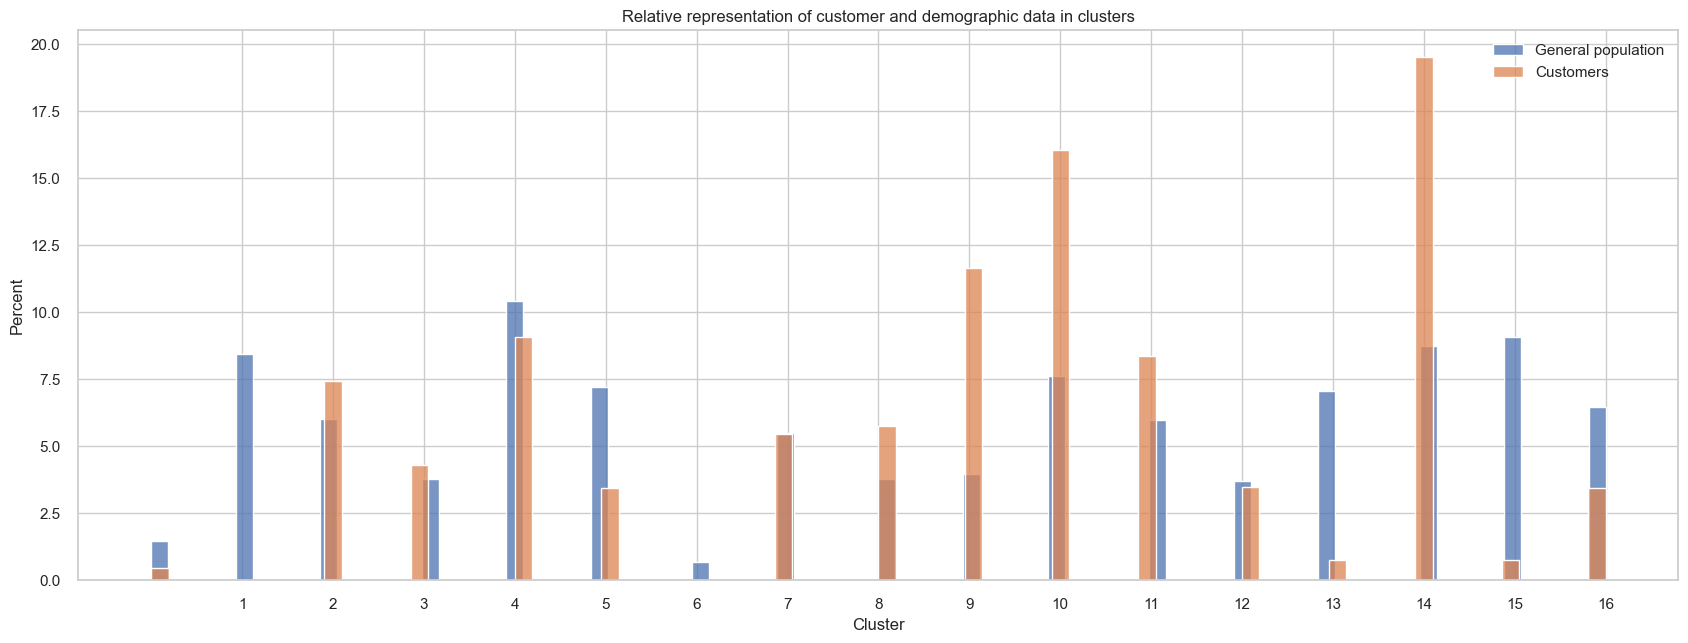

In [927]:
fig = plt.figure()
ax=fig.add_axes([0,0,2,1], title='Relative representation of customer and demographic data in clusters')
sns.set_style("whitegrid")
sns.histplot(azdias_general_pred, label='General population',ax=ax, stat='percent')
sns.histplot(predict_customers, label='Customers', ax=ax, stat='percent')
ax.set(xlabel='Cluster')
ax.set_xticks(np.arange(1,17))
ax.legend()

In [961]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

df_proportions = pd.DataFrame({'RelCust': np.unique(predict_customers, return_counts=True)[1]/len(predict_customers)*100,
                   'RelPop': np.unique(azdias_general_pred, return_counts=True)[1]/len(azdias_general_pred)*100})

df_proportions['DifRelPop'] = df_proportions['RelCust']-df_proportions['RelPop']

df_proportions['Repr'] = df_proportions['DifRelPop'].apply(lambda x: 'under' if x<0 else 'over') 
df_proportions.index.name = 'Cluster'
df_proportions.sort_values('DifRelPop')

,RelCust,RelPop,DifRelPop,Repr
Cluster,,,,
1,0.009173,8.453571,-8.444398,under
15,0.774034,9.078556,-8.304522,under
13,0.777562,7.083428,-6.305866,under
5,3.429176,7.230193,-3.801017,under
16,3.441171,6.473366,-3.032195,under
4,9.061210,10.424238,-1.363028,under
0,0.473452,1.486163,-1.012711,under
6,0.000706,0.681425,-0.680719,under
12,3.470101,3.703234,-0.233134,under


In [960]:
# for inverse_transform see https://knowledge.udacity.com/questions/99950 again
# values are rounded to take a look at ordinal features
# if numeric features were to be inspected in detail rounding wouldn't make sense

cluster_centroid = scaler.inverse_transform(pca.inverse_transform(model_general.cluster_centers_)).round()

df_inverse_transform = pd.DataFrame(data=cluster_centroid, columns=customers_clean.columns)
df_inverse_transform.index.name = 'Cluster'
df_inverse_transform.sample(5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_INTL_2015_HOUSEHOLD_0,CAMEO_INTL_2015_HOUSEHOLD_1,CAMEO_INTL_2015_HOUSEHOLD_2,CAMEO_INTL_2015_HOUSEHOLD_3,CAMEO_INTL_2015_HOUSEHOLD_4,CAMEO_INTL_2015_FAMILY_0,CAMEO_INTL_2015_FAMILY_1,CAMEO_INTL_2015_FAMILY_2,CAMEO_INTL_2015_FAMILY_3,CAMEO_INTL_2015_FAMILY_4
Cluster,,,,,,,,,,,,,,,,,,,,,
1,2.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,-0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,3.0,2.0,4.0,2.0,4.0,2.0,2.0,3.0,0.0,2.0,...,0.0,0.0,0.0,1.0,-0.0,0.0,0.0,1.0,0.0,0.0
4,3.0,2.0,3.0,2.0,4.0,2.0,2.0,4.0,0.0,2.0,...,-0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.0
8,3.0,2.0,4.0,2.0,4.0,3.0,2.0,3.0,0.0,2.0,...,0.0,0.0,0.0,1.0,-0.0,1.0,-0.0,0.0,0.0,0.0
16,3.0,1.0,3.0,2.0,4.0,2.0,2.0,4.0,0.0,2.0,...,0.0,0.0,1.0,-0.0,-0.0,0.0,-0.0,-0.0,1.0,0.0


In [935]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# top 3 overrepresented
df_proportions.sort_values('DifRelPop')[-3:]

,RelCust,RelPop,DifRelPop,Repr
Cluster,,,,
9,11.657082,3.980270,7.676813,over
10,16.052214,7.616068,8.436146,over
14,19.539954,8.727016,10.812938,over


The clusters indicated are the 3 most overrepresented clusters. Let's take a look a the inversed_transformed data.

In [958]:
# get feature information from cluster 14
df_inverse_transform.loc[14]

ALTERSKATEGORIE_GROB        3.0
ANREDE_KZ                   2.0
FINANZ_MINIMALIST           4.0
FINANZ_SPARER               2.0
FINANZ_VORSORGER            4.0
                           ... 
CAMEO_INTL_2015_FAMILY_0    0.0
CAMEO_INTL_2015_FAMILY_1    0.0
CAMEO_INTL_2015_FAMILY_2    1.0
CAMEO_INTL_2015_FAMILY_3    0.0
CAMEO_INTL_2015_FAMILY_4    0.0
Name: 14, Length: 210, dtype: float64

In [962]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# top 3 underrepresented
df_proportions.sort_values('DifRelPop')[:3]

,RelCust,RelPop,DifRelPop,Repr
Cluster,,,,
1,0.009173,8.453571,-8.444398,under
15,0.774034,9.078556,-8.304522,under
13,0.777562,7.083428,-6.305866,under


In [971]:
# get feature information from cluster 1
df_inverse_transform.loc[1, [col for col in customers_clean.columns if 'JUGEND' in col]]

JUGENDJAHRE_MAINSTREAM    1.0
JUGENDJAHRE_JAHRE         1.0
Name: 1, dtype: float64

In [1020]:
mask = np.where(df_inverse_transform.loc[1] != df_inverse_transform.loc[14], True, False)
# take a look at features where there is a difference between clusters 1 and 14
df_interesting = df_inverse_transform.T.iloc[mask, [14,1]]
df_interesting['diff'] = df_inverse_transform.T.iloc[mask, 14]- df_inverse_transform.T.iloc[mask, 1]
df_interesting.sort_values(by='diff', ascending=False).head()

Cluster,14,1,diff
LP_LEBENSPHASE_FEIN,20.0,7.0,13.0
SEMIO_VERT,5.0,1.0,4.0
ANZ_HAUSHALTE_AKTIV,3.0,0.0,3.0
KONSUMNAEHE,4.0,1.0,3.0
LP_LEBENSPHASE_GROB,6.0,3.0,3.0


### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

The analysis makes it clear that certain steps could have been abbreviated if communication with someone who created the dataset was possible, for example when checking for missing data. Moreover, it showed how every step of the project is crucial and can possibly affect the final outcome. It is not enough to work with a dataset, a certain degree of understanding is necessary to produce meaningful results. In terms of effort, preprocessing easily takes up the same amount as all the following steps. An interesting outcome is also that powerful mathematical tools such as PCA and KMeans for clustering, still require detailed manual analysis afterwards, for example the description of a cluster based on 79 features. Here is a simplified attempt to do this for the most over- and underrepresented clusters.

* cluster 14 ist most popular with Arvato:
    * CAMEO_INTL_2015_HOUSEHOLD_3 1.0, i.e. prosperous household
    * CAMEO_INTL_2015_FAMILY_2 1.0, i.e. older families & mature couples
    * ONLINE_AFFINITAET 3.0, i.e. high online affinity
    * FINANZ_ANLEGER 2.0, i.e. financial topoloy high investor 
    * FINANZ_UNAUFFAELLIGER 2.0, i.e. financial topology high inconspicuous
    * LP_LEBENSPHASE_FEIN 20.0, i.e. top earner couples of higher age
    * HH_EINKOMMEN_SCORE 4.0, i.e. average income
    
* cluster 1 is relatively unpopular with Arvato:
    * ONLINE_AFFINITAET 2.0, i.e. middle online affinity
    * FINANZ_ANLEGER 5.0, i.e. financial topology: very low investor
    * FINANZ_UNAUFFAELLIGER 5.0, i.e. financial topology: very low inconspicious
    * LP_LEBENSPHASE_FEIN 7.0, i.e. single average earners of advanced age
    * HH_EINKOMMEN_SCORE 2.0, i.e. very high income  
    
Inspecting two clusters shows that it is also necessary to validate the clusters or the input data of population and customers respectively. For example, it is unlogical how cluster 1 represents both people that are "single average earners of advanced age" and people of "very high household". However, such incosistency might already derive from inconsistent customer or population data but could also be a result of preprocessing such as most_frequent imputation.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.